### Kyivstar subscribers' binary classification. Define drivers among all subscribers.

The purpose of the task is to predict if the user belongs to the driver segment or not. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [53]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score
#from sklearn import metrics

### Reading data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
tabular_data = pd.read_csv('tabular_data.csv')
hashed_feature = pd.read_csv('hashed_feature.csv')

The tabular_data.csv contains numerical data on the subscriber's activity for 12 periods. </br>
-period - period number (consecutive periods, 1 - the newest);</br>
-id - subscriber ID;</br>
-feature_0 - feature_49 - data on the subscriber's activity in the corresponding period.

The hashed_feature.csv is a set of hashed values of one categorical variable for the subscriber.

In [4]:
tabular_data.head()

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,1,110.0,55.0,0.432017,0.000000,176.78,0.0,0.323712,NaN,...,0.00,0,0.000000,0.0,55.0,2.0,0.526552,145.0,133.28,0.0
1,0,2,110.0,110.0,0.397517,0.000000,315.42,0.0,0.316798,NaN,...,0.00,0,0.000000,0.0,110.0,1.0,0.481063,130.0,229.97,0.0
2,0,3,110.0,55.0,0.359440,0.000000,354.55,0.0,0.339188,NaN,...,0.07,0,0.000000,0.0,55.0,1.0,0.509598,180.0,231.78,0.0
3,0,4,110.0,55.0,0.285707,0.000000,229.98,0.0,0.415428,NaN,...,0.00,0,0.000000,0.0,55.0,0.0,0.680089,142.0,183.83,0.0
4,0,5,110.0,55.0,0.101487,444.730391,307.12,0.0,0.569670,NaN,...,0.95,0,20.014485,0.0,55.0,0.0,0.776175,85.0,155.83,0.0


In [5]:
print('Train:{}, Test:{}, Tabular:{}, Hashed:{}'.format(train.shape, test.shape, tabular_data.shape, hashed_feature.shape))

Train:(4084, 2), Test:(1022, 2), Tabular:(61272, 52), Hashed:(266053, 2)


In [6]:
tabular_data.describe()

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
count,61272.000000,61272.000000,58460.000000,58380.000000,57795.000000,58314.000000,58425.000000,58257.000000,57814.000000,58280.000000,...,58402.000000,61272.0,58389.000000,58218.000000,58428.000000,58307.000000,53036.000000,58418.000000,58368.000000,58397.000000
mean,2552.500000,6.500000,110.070493,87.142409,0.305150,3003.454276,414.703826,1466.527398,0.576053,391.127914,...,2.389240,0.0,451.453999,1.092617,70.045547,12.617404,0.420170,125.407494,288.885904,62.298690
std,1473.987237,3.452081,0.465371,95.507541,0.746314,11218.392268,524.216185,7356.174585,0.738444,436.314898,...,12.291543,0.0,2784.078472,2.989411,60.523556,22.794809,0.402705,123.970687,380.992122,341.761943
min,0.000000,1.000000,110.000000,-4.250000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,...,-234.610000,0.0,-71832.185113,0.000000,0.000000,0.000000,-0.999903,0.000000,0.000000,0.000000
25%,1276.000000,3.750000,110.000000,45.000000,0.059522,0.000000,70.320000,0.000000,0.247418,99.295000,...,0.000000,0.0,0.000000,0.000000,35.000000,1.000000,0.084032,39.000000,38.845000,0.000000
50%,2552.500000,6.500000,110.000000,75.000000,0.147504,10.898701,254.950000,0.000000,0.492813,262.430000,...,0.150000,0.0,0.000000,0.000000,61.580000,5.000000,0.412981,94.000000,168.250000,3.000000
75%,3829.000000,9.250000,110.000000,114.000000,0.321111,1809.999746,566.530000,0.000000,0.698059,535.162500,...,1.630000,0.0,17.765874,1.000000,95.000000,14.000000,0.791630,173.000000,393.807500,13.000000
max,5105.000000,12.000000,119.000000,7989.000000,5.474424,557998.502178,10335.280000,334448.528357,5.499928,7950.650000,...,1063.930000,0.0,150799.228494,31.000000,1189.000000,504.000000,0.999941,1724.000000,8201.170000,2452.540251


The mean and standard deviation for all columns is a highly difference. 

In [7]:
tabular_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61272 entries, 0 to 61271
Data columns (total 52 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          61272 non-null  int64  
 1   period      61272 non-null  int64  
 2   feature_0   58460 non-null  float64
 3   feature_1   58380 non-null  float64
 4   feature_2   57795 non-null  float64
 5   feature_3   58314 non-null  float64
 6   feature_4   58425 non-null  float64
 7   feature_5   58257 non-null  float64
 8   feature_6   57814 non-null  float64
 9   feature_7   58280 non-null  float64
 10  feature_8   58338 non-null  float64
 11  feature_9   58344 non-null  float64
 12  feature_10  58318 non-null  float64
 13  feature_11  58184 non-null  float64
 14  feature_12  57847 non-null  float64
 15  feature_13  57938 non-null  float64
 16  feature_14  58366 non-null  float64
 17  feature_15  58410 non-null  float64
 18  feature_16  58193 non-null  float64
 19  feature_17  61272 non-nul

Most of all columns are numeric and one should be encoded. 

In [10]:
tabular_data['period'].value_counts()

12    5106
11    5106
10    5106
9     5106
8     5106
7     5106
6     5106
5     5106
4     5106
3     5106
2     5106
1     5106
Name: period, dtype: int64

Periods have equal numbers of data

In [11]:
train['target'].value_counts()

0    3009
1    1075
Name: target, dtype: int64

Data is unbalanced. The 'zero'/not driver results has more examples then 'one'/driver

### Tabular Data

#### Encoding Features

One of the columns is an object. Let's look at it closly

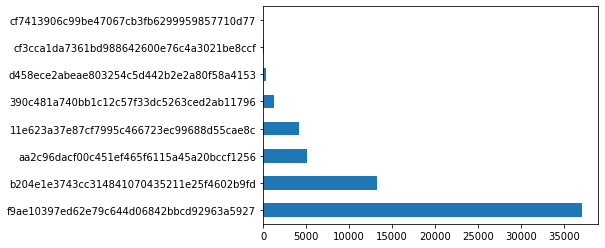

In [8]:
tabular_data['feature_25'].value_counts().plot.barh();

I will start with Label Encoder for this feature, as there are not a lot of unigue values

In [9]:
le = LabelEncoder()
tabular_data['feature_25'] = le.fit_transform(tabular_data['feature_25'])

#### Missing values

In [12]:
is_null_data = tabular_data.isnull()
total = is_null_data.sum()
percent = ((total/tabular_data.isnull().count())*100)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data.sort_values(by = 'Percent', ascending=False)

,Total Missing,Percent
feature_46,8236,13.441703
feature_33,3778,6.165949
feature_19,3564,5.816686
feature_2,3477,5.674696
feature_6,3458,5.643687
feature_12,3425,5.589829
feature_13,3334,5.441311
feature_23,3099,5.057775
feature_11,3088,5.039822
feature_16,3079,5.025134


A few missing data columns, but with not a huge percent

In [13]:
#savig id column
id_col = tabular_data['id'].copy()

In [14]:
#Filling missing NaN values with mean for all periods 
tabular_data.groupby('id', as_index = False).mean()

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,6.5,110.000000,60.916667,0.238880,293.635812,430.134167,0.000000,0.445332,NaN,...,0.425000,0.0,11.535962,0.000000,59.875000,0.750000,0.508078,142.833333,315.011667,0.250000
1,1,6.5,110.000000,135.541667,0.060443,6940.579852,1119.352500,0.000000,0.350638,1199.843333,...,1.636667,0.0,3385.043551,0.083333,125.000000,6.750000,0.331702,135.916667,NaN,204.334131
2,2,6.5,110.166667,0.597500,5.203073,0.141369,4.168333,0.000000,0.875014,NaN,...,0.456667,0.0,0.000082,0.000000,0.597500,0.000000,0.195109,10.083333,2.470000,0.000000
3,3,6.5,110.000000,62.500000,2.589315,1515.795679,75.613333,0.000000,0.695500,164.350000,...,0.680000,0.0,0.163807,0.666667,51.376667,1.000000,0.690459,106.000000,55.316667,6.666667
4,4,6.5,110.000000,126.000000,0.133693,2568.283478,460.332500,0.000000,1.006855,522.449167,...,3.381667,0.0,162.972195,0.166667,103.733333,36.333333,0.819175,190.333333,NaN,208.911004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5101,5101,6.5,110.000000,94.166667,0.292280,180.142899,1218.388333,98.211165,0.465432,1430.785833,...,0.269167,0.0,35.789269,0.000000,91.667500,12.083333,NaN,167.250000,858.400833,6.500000
5102,5102,6.5,110.000000,80.675000,0.755737,0.000000,215.499167,0.000000,0.772686,144.782500,...,0.862500,0.0,0.000000,0.416667,74.583333,8.500000,0.453970,102.416667,187.505833,1.666667
5103,5103,6.5,110.250000,22.568333,0.801533,0.000000,145.231667,0.000000,0.851162,64.091667,...,2.669167,0.0,0.000000,0.333333,20.833333,5.583333,0.352421,17.250000,NaN,7.666667
5104,5104,6.5,110.000000,86.230833,0.068594,988.894377,72.641667,0.000000,0.548337,73.720000,...,0.547500,0.0,190.904901,0.416667,85.314167,4.333333,0.714110,60.916667,49.870833,4.583333


In [15]:
tabular_data.groupby('id', as_index = False)\
                             .transform(lambda x: x.fillna(np.mean(x)))\
                             .reset_index()\
                             .rename(columns={'index':'id'})

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,1,110.0,55.0,0.432017,0.000000,176.78,0.0,0.323712,NaN,...,0.00,0,0.000000,0.0,55.0,2.0,0.526552,145.0,133.28,0.0
1,1,2,110.0,110.0,0.397517,0.000000,315.42,0.0,0.316798,NaN,...,0.00,0,0.000000,0.0,110.0,1.0,0.481063,130.0,229.97,0.0
2,2,3,110.0,55.0,0.359440,0.000000,354.55,0.0,0.339188,NaN,...,0.07,0,0.000000,0.0,55.0,1.0,0.509598,180.0,231.78,0.0
3,3,4,110.0,55.0,0.285707,0.000000,229.98,0.0,0.415428,NaN,...,0.00,0,0.000000,0.0,55.0,0.0,0.680089,142.0,183.83,0.0
4,4,5,110.0,55.0,0.101487,444.730391,307.12,0.0,0.569670,NaN,...,0.95,0,20.014485,0.0,55.0,0.0,0.776175,85.0,155.83,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61267,61267,8,110.0,77.0,NaN,0.000000,95.30,0.0,0.094381,221.85,...,-0.00,0,0.000000,0.0,75.0,0.0,0.082128,43.0,83.97,0.0
61268,61268,9,110.0,77.0,NaN,0.000000,61.87,0.0,0.105878,343.22,...,1.75,0,0.000000,0.0,75.0,0.0,0.077594,49.0,48.02,0.0
61269,61269,10,110.0,106.5,NaN,0.000000,88.05,0.0,0.040169,259.33,...,8.27,0,0.000000,0.0,99.0,1.0,0.109053,43.0,74.52,0.0
61270,61270,11,110.0,45.0,NaN,0.000000,98.40,0.0,0.040810,222.00,...,0.00,0,0.000000,0.0,0.0,0.0,0.101929,35.0,25.83,0.0


In [16]:
#putting id column back
tabular_data['id'] = id_col

Filling other missing values with 0 as there are no data for the user on any period.

In [17]:
tabular_data.fillna(0, inplace = True)

In [18]:
# check if I don't miss any row
tabular_data.shape

(61272, 52)

The number of rows is equal

In [20]:
tabular_data.head()

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,1,110.0,55.0,0.432017,0.000000,176.78,0.0,0.323712,0.0,...,0.00,0,0.000000,0.0,55.0,2.0,0.526552,145.0,133.28,0.0
1,0,2,110.0,110.0,0.397517,0.000000,315.42,0.0,0.316798,0.0,...,0.00,0,0.000000,0.0,110.0,1.0,0.481063,130.0,229.97,0.0
2,0,3,110.0,55.0,0.359440,0.000000,354.55,0.0,0.339188,0.0,...,0.07,0,0.000000,0.0,55.0,1.0,0.509598,180.0,231.78,0.0
3,0,4,110.0,55.0,0.285707,0.000000,229.98,0.0,0.415428,0.0,...,0.00,0,0.000000,0.0,55.0,0.0,0.680089,142.0,183.83,0.0
4,0,5,110.0,55.0,0.101487,444.730391,307.12,0.0,0.569670,0.0,...,0.95,0,20.014485,0.0,55.0,0.0,0.776175,85.0,155.83,0.0


### Hashed Feature

In [21]:
hashed_feature['feature_50'].nunique()

5009

This feature has a lot of unique values

In [22]:
hashed_feature['feature_50'].value_counts()

7984b0a0e139cabadb5afc7756d473fb34d23819    2531
732859d808df41a0c340c31a4ab55f6f8f77af42    1561
bc69c5b3e3892ae2d63629bc2c916cb67f17feaa     819
f4f7e30d6604756613a7c203ddd63cd93fe0f0b0     686
5a214d3b3a3f26cab544d931ad211881b1e3e4d2     621
                                            ... 
6c89813db6427d838664a4eda9280cfb8c788a60       1
7a0a1305fa7a430537e3070f0fa491e4a7479b8b       1
9b0b265a0989730f66d9e749b93d46575154854f       1
3b5fad4bf092bf9c2eb20f1d9a9890ebbfc64271       1
537de0ccb080e8be825389b12cfb27e7f7559623       1
Name: feature_50, Length: 5009, dtype: int64

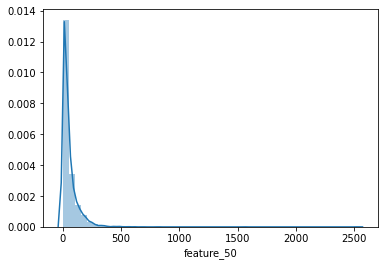

In [23]:
sns.distplot(hashed_feature['feature_50'].value_counts());

Some values are realy rare. 
I think these are towers to which subscribers were connected

#### Missing values

In [24]:
hashed_feature.isnull().sum()

id              0
feature_50    404
dtype: int64

In [26]:
#filling missing values with mode
hashed_feature['feature_50'].fillna('mode', inplace = True)

#### Encoding Features

In [27]:
hashed_feature['feature_50_LE'] = le.fit_transform(hashed_feature['feature_50'])

In [28]:
onehot_encoder = OneHotEncoder()
hashed_feature['feature_50_OHE'] = onehot_encoder.fit_transform(hashed_feature[['feature_50']])

### Split and divide data

Splitting data for train and test to one period with mean for an each user.

In [29]:
train_data = tabular_data.loc[:49008].groupby(['id'],as_index=False).mean()

In [30]:
test_data = tabular_data.loc[49008:].groupby(['id'],as_index=False).mean()

In [31]:
train_data = train_data.merge(train, on = 'id')

In [32]:
#creating new feature 'Number of heshaed feature' for each user
number_of_HF = hashed_feature.groupby('id')['feature_50'].count()

In [33]:
number_of_HF.head()

id
0    10
1    43
2    15
3     6
4    52
Name: feature_50, dtype: int64

In [34]:
#merge new feature with train data
train_data = train_data.merge(number_of_HF, on = 'id')

In [35]:
test_data = test_data.merge(number_of_HF, on = 'id')

In [36]:
print('Train:{}, Test:{}'.format(train_data.shape, test_data.shape))

Train:(4084, 54), Test:(1022, 53)


#### Correlation

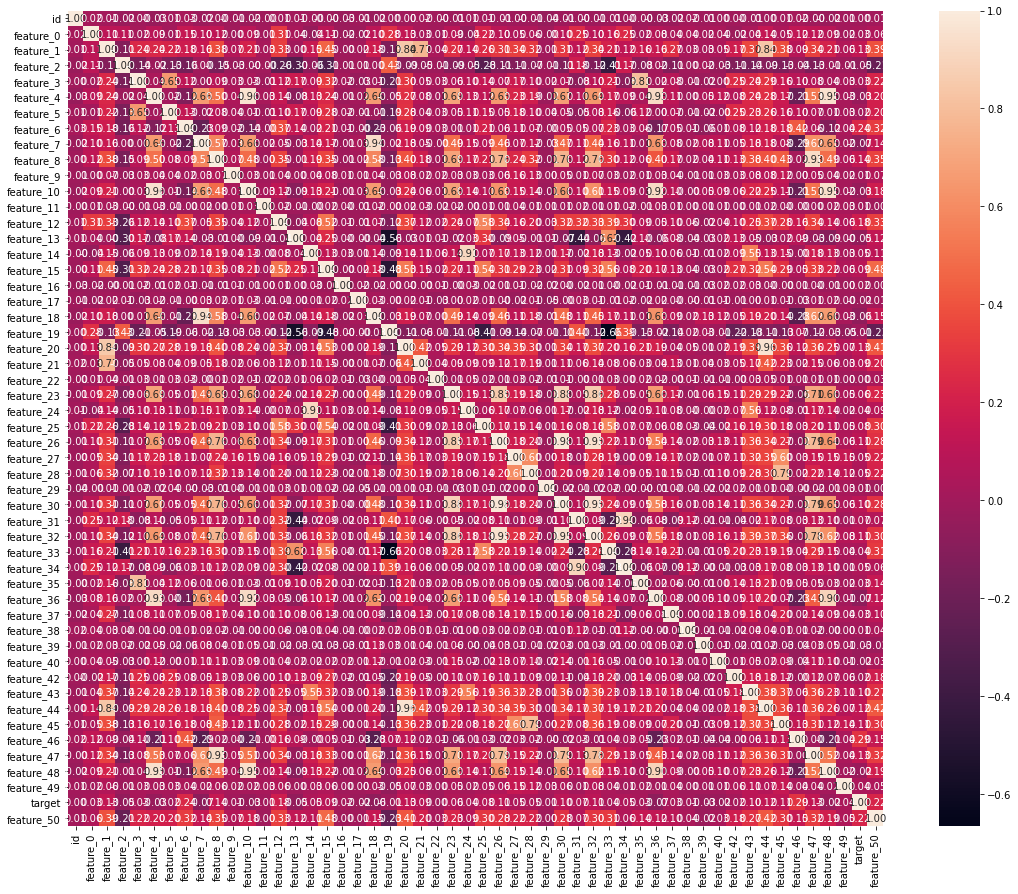

In [43]:
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(train_data.corr(), annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

There are no strong correlation beetwen target and features, but some features higly correlated with each others.

In [38]:
train_data['feature_41'].sum()

0.0

In [ ]:
#removing an empty feature
train_data.drop(['period','feature_41'], axis = 1, inplace = True)

### Imbalanced data

As data are imbalanced, we can try to add more examples for drivers

In [44]:
y = train['target']

In [45]:
train_data.drop(['id', 'target'], axis = 1, inplace = True)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.3, random_state=27)

In [47]:
X = pd.concat([X_train, y_train], axis=1)

#### Oversampling Minority Class

In [48]:
# separate minority and majority classes
not_driver = X[X['target']==0]
driver = X[X['target']==1]

# upsample minority
driver_upsampled = resample(driver,
                          replace=True, # sample with replacement
                          n_samples=len(not_driver), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_driver, driver_upsampled])

# check new class counts
upsampled['target'].value_counts()

1    2134
0    2134
Name: target, dtype: int64

Now number of examples is equal.

In [49]:
y_train = upsampled['target']
X_train = upsampled.drop('target', axis = 1)

In [44]:
#normalization
#X_train = preprocessing.normalize(X_train)

### Models

In [51]:
from xgboost import XGBClassifier

In [54]:
models = []

models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc'

for name, model in models:
  #  cv_results = cross_val_score(model, X_train, y_train, scoring = scoring)
  #  results.append(cv_results)
    names.append(name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('{}: {}'.format(name, roc_auc_score(y_test, y_pred)))
    print('---------------------------------------------------')

LDA: 0.6725046805046805
---------------------------------------------------
KNN: 0.5185038665038665
---------------------------------------------------
NB: 0.5983931623931624
---------------------------------------------------
SVM: 0.5
---------------------------------------------------
XGB: 0.668884004884005
---------------------------------------------------


In [55]:
clf = XGBClassifier()

In [56]:
clf.fit(X_train, y_train)

XGBClassifier()

In [57]:
y_pred = clf.predict(X_test)

In [58]:
y_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [59]:
print('Roc Auc: {}'.format(roc_auc_score(y_test, y_pred)))

Roc Auc: 0.668884004884005


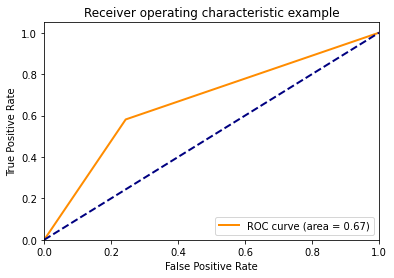

In [61]:
#ROC Visualistion
lw = 2
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Final ROC_UAC score is near 67%. 

### Submit

In [62]:
test_data.set_index('id', inplace = True)

In [63]:
test_data.drop(['period', 'feature_41'], axis = 1, inplace = True)

In [64]:
predictions = clf.predict(test_data)

In [65]:
predictions_prob = clf.predict_proba(test_data)

In [66]:
test['score'] = predictions_prob[:,1]

In [67]:
test

,id,score
0,4084,0.097799
1,4085,0.121960
2,4086,0.140845
3,4087,0.477914
4,4088,0.595721
...,...,...
1017,5101,0.205757
1018,5102,0.602099
1019,5103,0.371414
1020,5104,0.536559


In [68]:
test.to_csv('MiroshnychenkoOleksandryna_test.csv', index = False)